In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

def generate_default_plot_env():
    sns.set(font_scale=1.4, style="whitegrid")
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rc('font', family='sans-serif') 
    matplotlib.rc('font', serif='Helvetica Neue') 
    matplotlib.rc('text', usetex='false') 
    matplotlib.rcParams.update({'font.size': 22})
    
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rc('font', family='sans-serif') 
    plt.rc('font', serif='Helvetica Neue') 
    plt.rc('text', usetex='false') 
    plt.rcParams.update({'font.size': 22})

In [2]:
generate_default_plot_env()

In [14]:
def plot_timeseries_change_loc(data_df, from_loc, to_loc,
                               use_bins=False, come_from=None, 
                               axis_fontsize=None, category_fontsize=None,
                               ylim=None, dotted_midpoint=False,
                               auto_linestyle=False,
                               
                               # Aesthetics
                               linewidth=10.,
                               frame_color='#3f6d32',
                               left_color='#590059',
                               right_color='#d77e2d',
                               left_linestyle='-', 
                               right_linestyle='-',
                               middle_text_rotation=45,
                               
                               # Legend
                               use_from_string=None,
                               use_to_string=None,
                               lgd_loc=None):
    
    if auto_linestyle:
        if from_loc == '*':
            left_linestyle = '--'
            temp = left_color
            left_color = right_color
            right_color = temp
        
        if to_loc == '*':
            right_linestyle = '--'

    f, ax = plt.subplots(figsize=(20,10))
    ax.grid(False)
    
    plot_x = 'move_relative_day_bin'
    unique_rel_days = list(pd.unique(data_df[plot_x]))

    sns.pointplot(x=data_df[plot_x], y=data_df["mean"].iloc[:3].tolist() + [np.nan]*4,
                  color=left_color,
                  linestyles=left_linestyle,
                  ci=None,
                  # size=5, aspect=3, 
                  scale=linewidth/4.,
                  ax=ax)

    sns.pointplot(x=data_df[plot_x], y=[np.nan]*4 + data_df["mean"].iloc[-3:].tolist(),
                  color=right_color,
                  linestyles=right_linestyle,
                  ci=None,
                  # size=5, aspect=3, 
                  scale=linewidth/4.,
                  ax=ax)

    x_loc = [unique_rel_days.index(val) if '-' in val else unique_rel_days.index(val) for val in data_df[plot_x]]
    ax.errorbar(x=x_loc, y=data_df['mean'], 
                yerr=[data_df['bottom_ci'], data_df['top_ci']], 
                linestyle="None", ecolor=[left_color]*4 + [right_color]*3,
                elinewidth=linewidth)

    from_string = str(from_loc) if from_loc != '*' else ('Less Walkable Locations' if come_from == 'below' else 'More Walkable Locations')
    to_string = str(to_loc) if to_loc != '*' else ('Less Walkable Locations' if come_from == 'above' else 'More Walkable Locations')

    ax.set(xlabel=r'Days from Move $\left(t - t_{move}\right)$', ylabel='Daily Steps')
    if ylim is not None:
        ax.set_ylim(bottom=ylim[0], top=ylim[1])

    ax.axvline(x=3, color='#b0b0b0', linewidth=0.8, zorder=-1)
    ax.text(0.5, 0.5, ' Relocation ', 
            fontsize=axis_fontsize+10, 
            rotation=middle_text_rotation,
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes,
            bbox=dict(boxstyle='rarrow', fc='white', ec=frame_color, alpha=1.0, linewidth=linewidth/2.))

    lw = 7.
    markersize = 20.
    line_left_point_dot, = plt.plot([], [], color=left_color, ls=left_linestyle, lw=lw, marker="o", markersize=markersize)
    line_right_point_dot, = plt.plot([], [], color=right_color, ls=right_linestyle, lw=lw, marker="o", markersize=markersize)

    if use_bins or from_loc == '*':
        from_lgd_string = r'%s ($\mu_{Walkability} = %d$)' % (from_string if use_from_string is None else use_from_string,
                                                       int(left_ws))
    else:
        from_lgd_string = '%s (Walkability %d)' % (from_string if use_from_string is None else use_from_string,
                                                   int(left_ws))

    if use_bins or to_loc == '*':
        to_lgd_string = r'%s ($\mu_{Walkability} = %d$)' % (to_string if use_to_string is None else use_to_string,
                                                      int(right_ws))
    else:
        to_lgd_string = '%s (Walkability %d)' % (to_string if use_to_string is None else use_to_string,
                                                 int(right_ws))

    lgd = ax.legend([line_left_point_dot, 
                     line_right_point_dot], 
                    [from_lgd_string, 
                     to_lgd_string], 
                    loc=lgd_loc if lgd_loc is not None else 'best',
                    frameon=True,
                    fontsize=axis_fontsize);

    def no_bracket_left(string):
        if '[' in string: 
            string = string.replace('[', '')
        if ']' in string: 
            string = string.replace(']', '')
        if '(' in string: 
            string = string.replace('(', '')
        if ')' in string: 
            string = string.replace(')', '')

        [left, right] = [int(val) for val in string.split(', ')]

        return_str = str(left) + ' to ' + str(right - 1)
        return return_str

    a = [no_bracket_left(val.get_text()) for val in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticklabels(a)

    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(axis_fontsize)

    # Custom larger title size
    ax.title.set_fontsize(axis_fontsize*1.2)

    plt.tight_layout()
    
    return ax

In [15]:
def add_middle(df):
    assert len(df) == 6

    mid_left_idx = len(df)//2-1
    mid_left = df["move_relative_day_bin"].iloc[mid_left_idx]
    mid_right = df["move_relative_day_bin"].iloc[mid_left_idx+1]

    mid_start = mid_left.split(", ")[-1][:-1]
    mid_end = mid_right.split(", ")[0][1:]

    mid_text = "[%s, %s)" % (mid_start, mid_end)

    df.loc[2.5] = (mid_text, np.nan, np.nan, np.nan)
    return df.sort_index().reset_index(drop=True)

In [16]:
axis_fontsize = 30
category_fontsize = 30

/tmp/ipykernel_95703/28736285.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=data_df["mean"].iloc[:3].tolist() + [np.nan]*4,
/tmp/ipykernel_95703/28736285.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=[np.nan]*4 + data_df["mean"].iloc[-3:].tolist(),
/tmp/ipykernel_95703/28736285.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=data_df["mean"].iloc[:3].tolist() + [np.nan]*4,
/tmp/ipykernel_95703/28736285.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=[np.nan]*4 + data_df["mean"].iloc[-3:].tolist(),


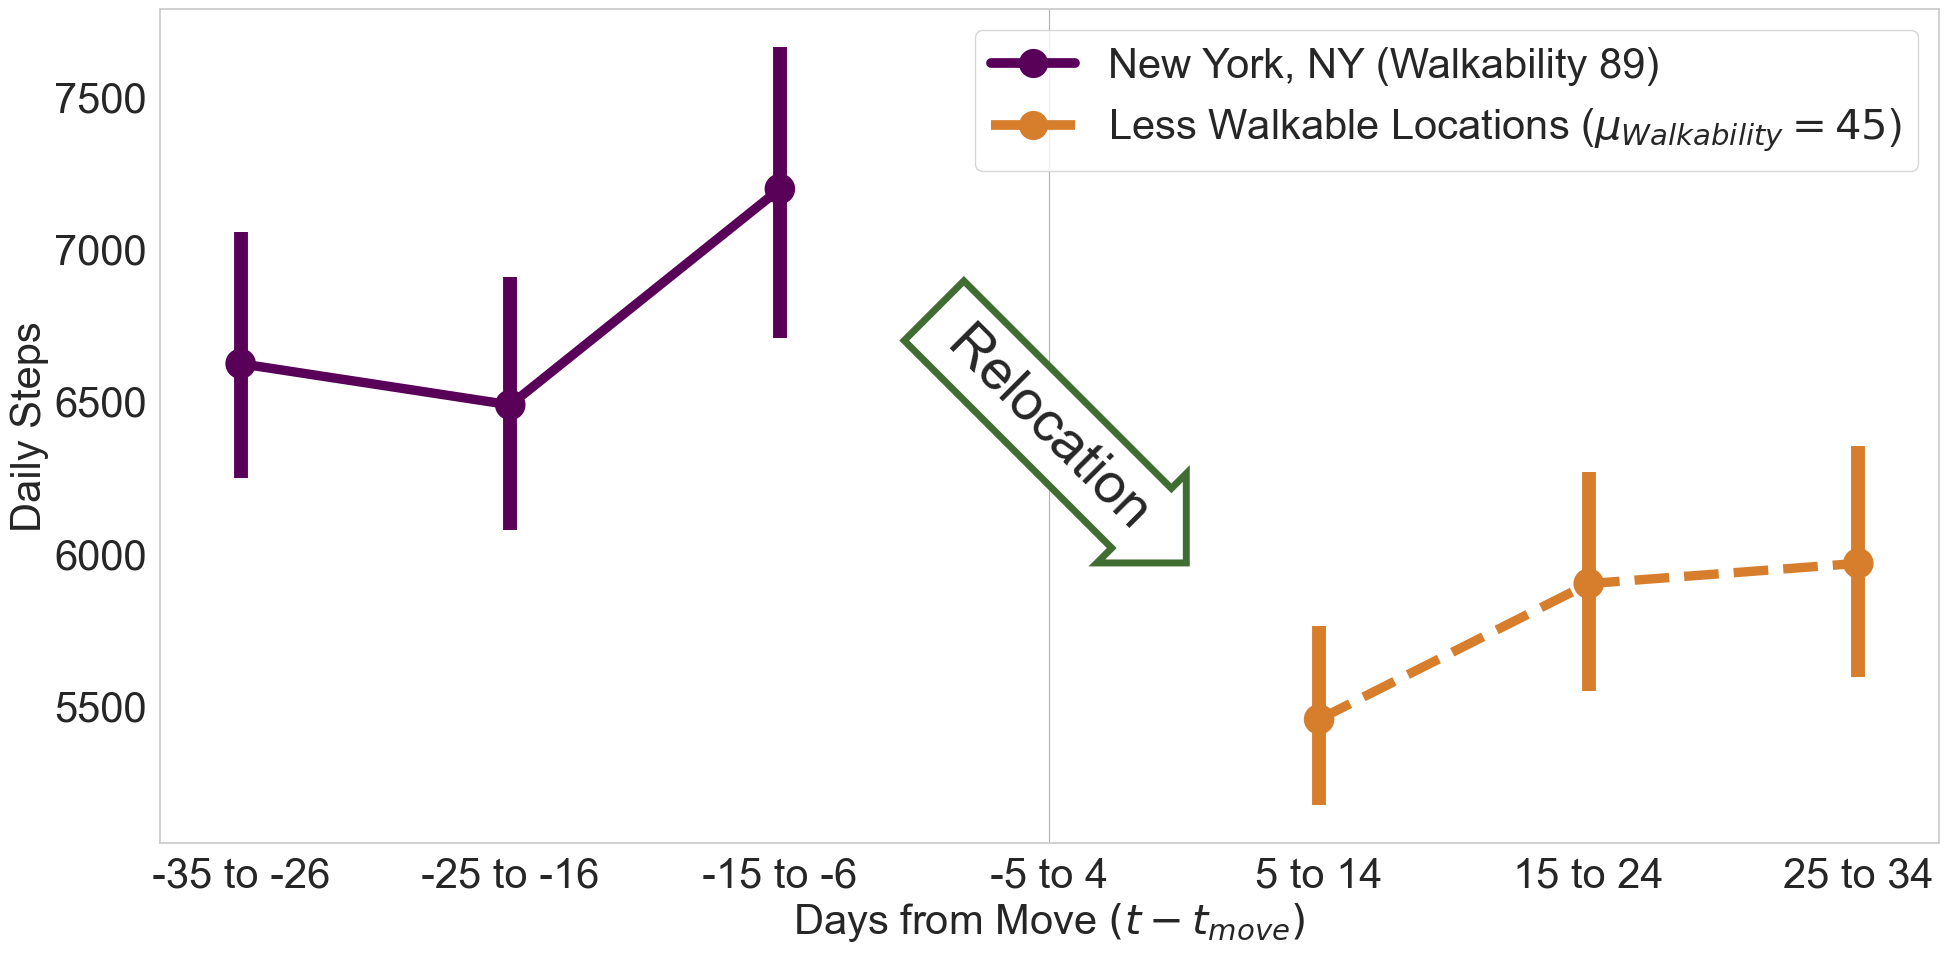

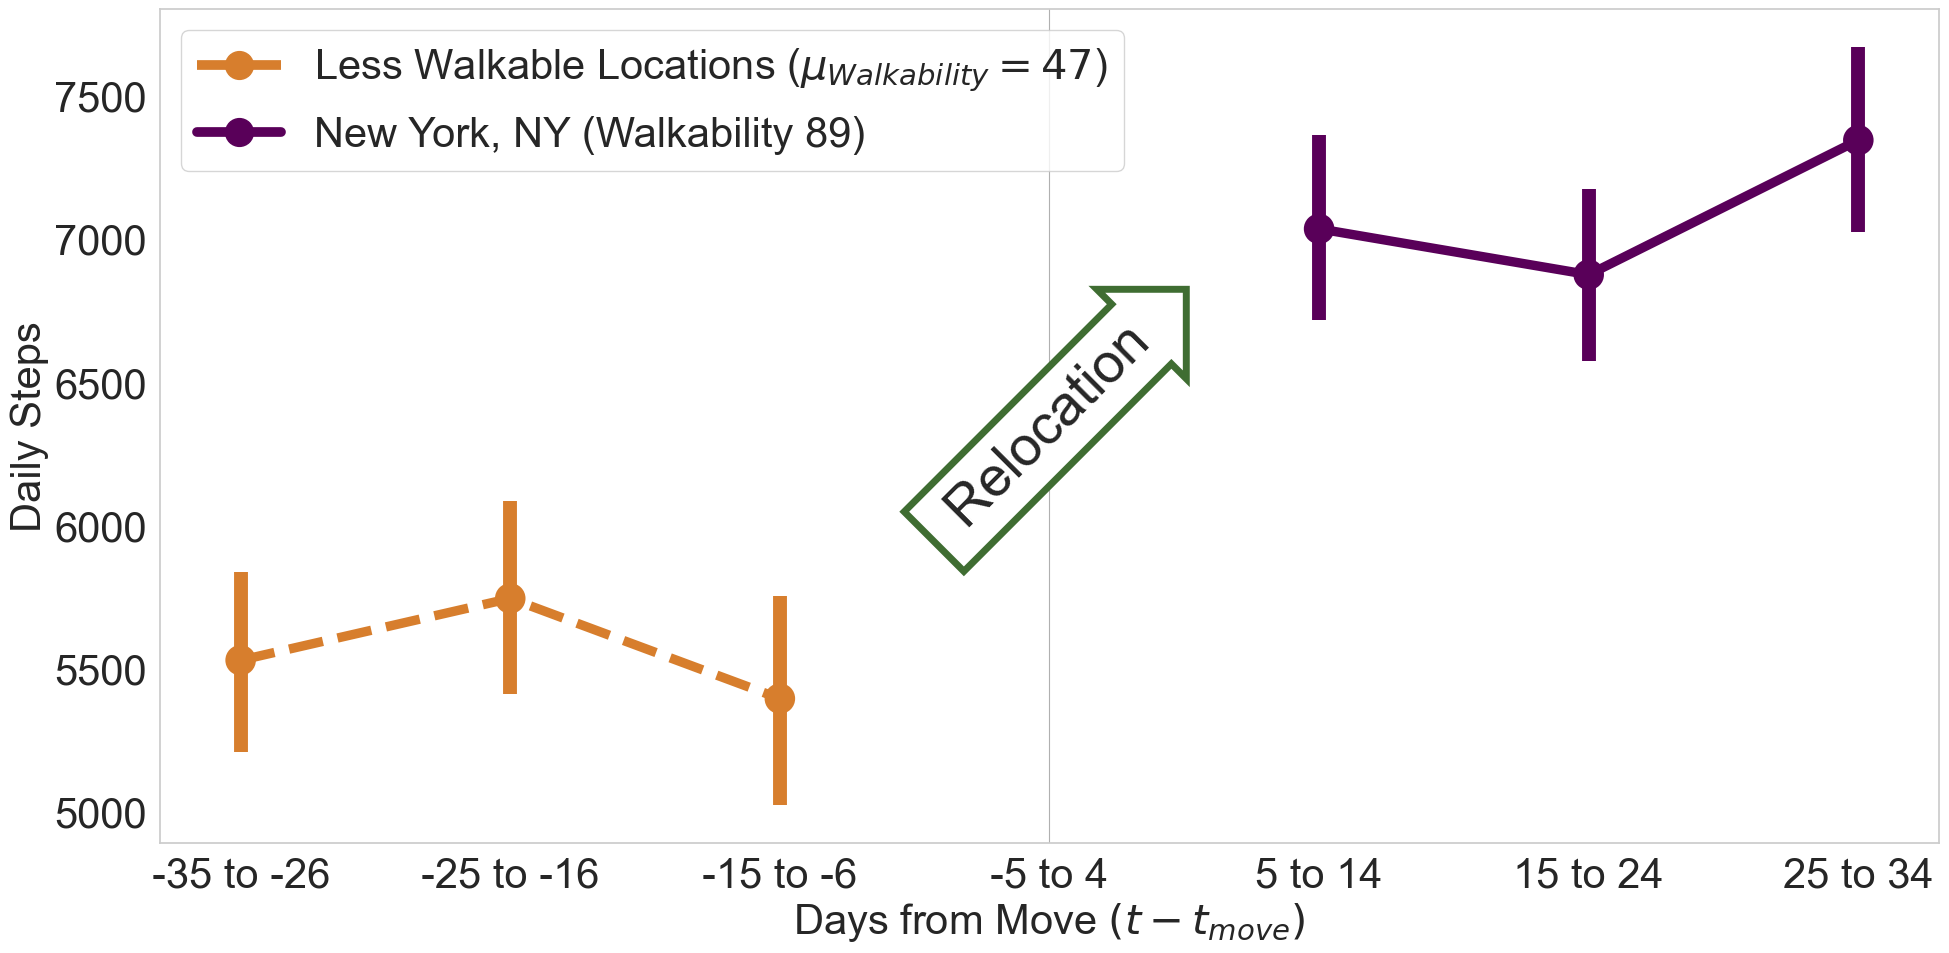

In [17]:
location = "New York, NY"
left_ws = 89
right_ws = 45

data_df = add_middle(pd.read_csv("../data/fig4/from_New_York_NY.csv")[
    ["move_relative_day_bin", "mean", "top_ci", "bottom_ci"]
])

ax = plot_timeseries_change_loc(data_df, location, '*',
                           come_from='above',
                           axis_fontsize=axis_fontsize, category_fontsize=category_fontsize,
                           middle_text_rotation=-45,
                           auto_linestyle=True)

plt.savefig("../output/fig4a.pdf", dpi=300)


left_ws = 47
right_ws = 89

data_df = add_middle(pd.read_csv("../data/fig4/to_New_York_NY.csv")[
    ["move_relative_day_bin", "mean", "top_ci", "bottom_ci"]
])

ax = plot_timeseries_change_loc(data_df, '*', location, 
                           come_from="below",
                           axis_fontsize=axis_fontsize, category_fontsize=category_fontsize,
                           middle_text_rotation=45,
                           auto_linestyle=True,
                           lgd_loc="upper left")

plt.savefig("../output/fig4b.pdf", dpi=300)

/tmp/ipykernel_95703/28736285.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=data_df["mean"].iloc[:3].tolist() + [np.nan]*4,
/tmp/ipykernel_95703/28736285.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=[np.nan]*4 + data_df["mean"].iloc[-3:].tolist(),
/tmp/ipykernel_95703/28736285.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=data_df["mean"].iloc[:3].tolist() + [np.nan]*4,
/tmp/ipykernel_95703/28736285.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=[np.nan]*4 + data_df["mean"].iloc[-3:].tolist(),


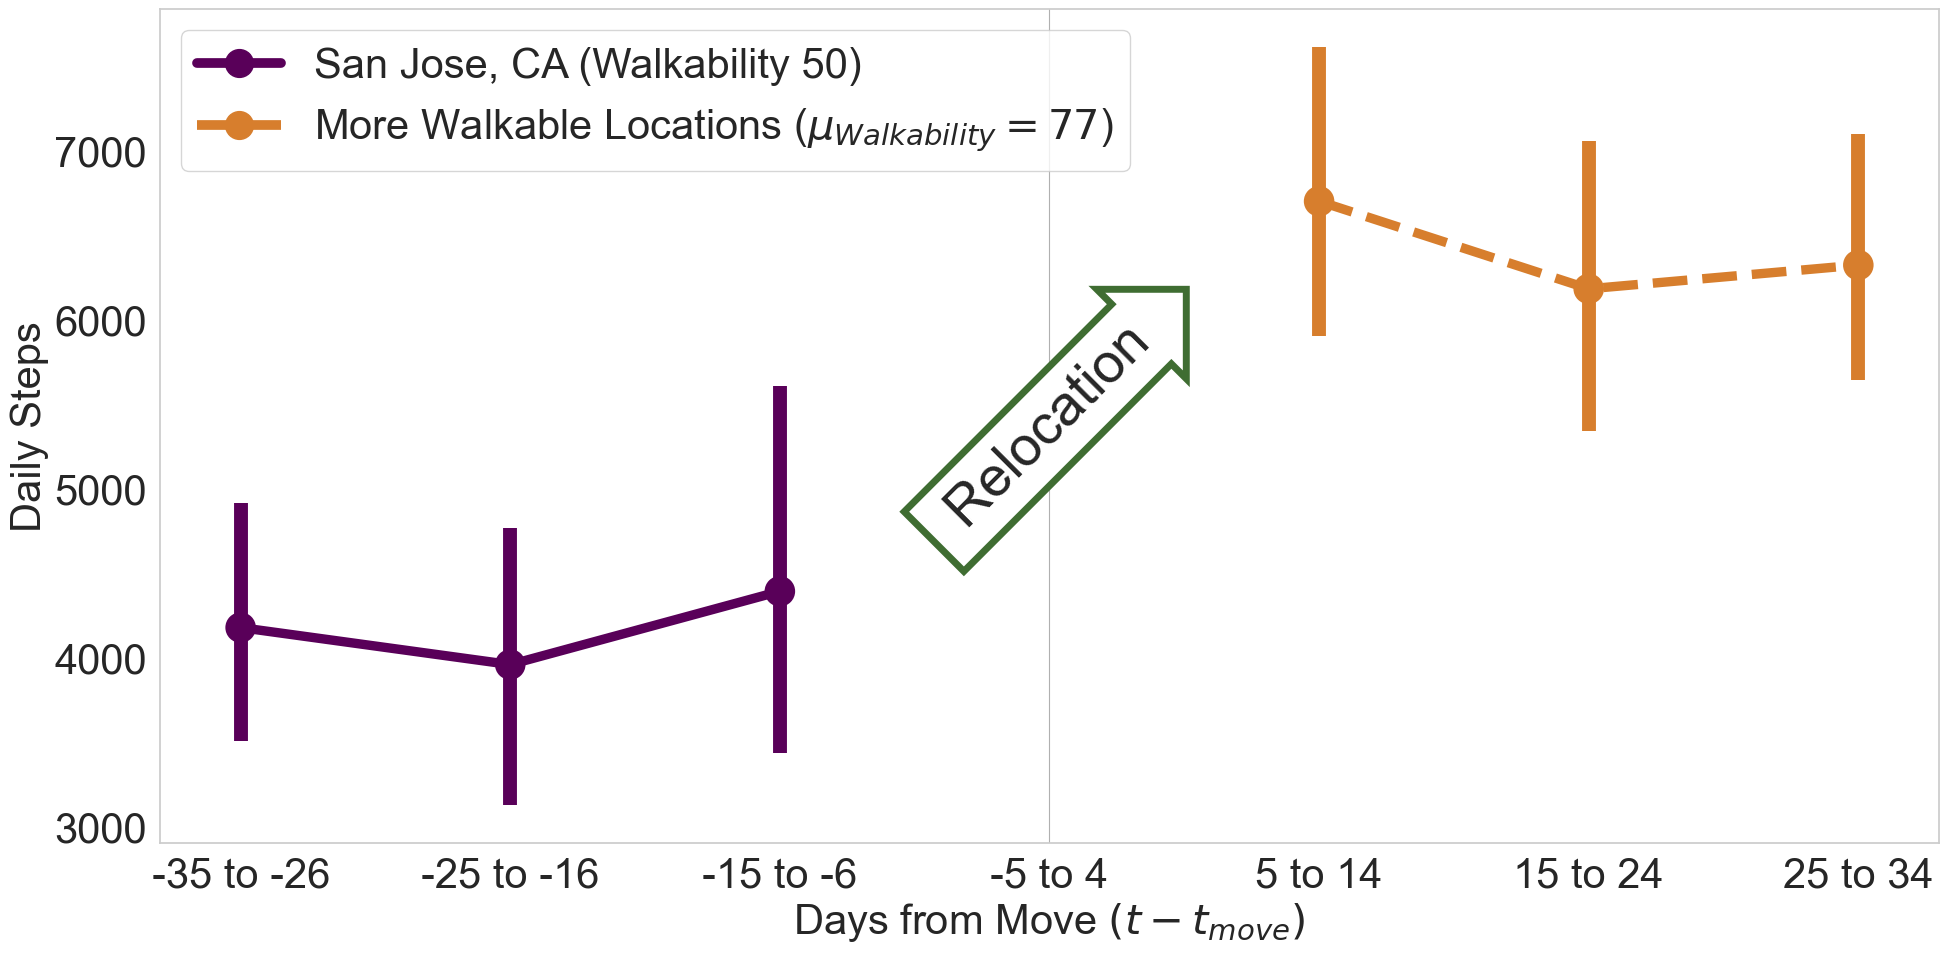

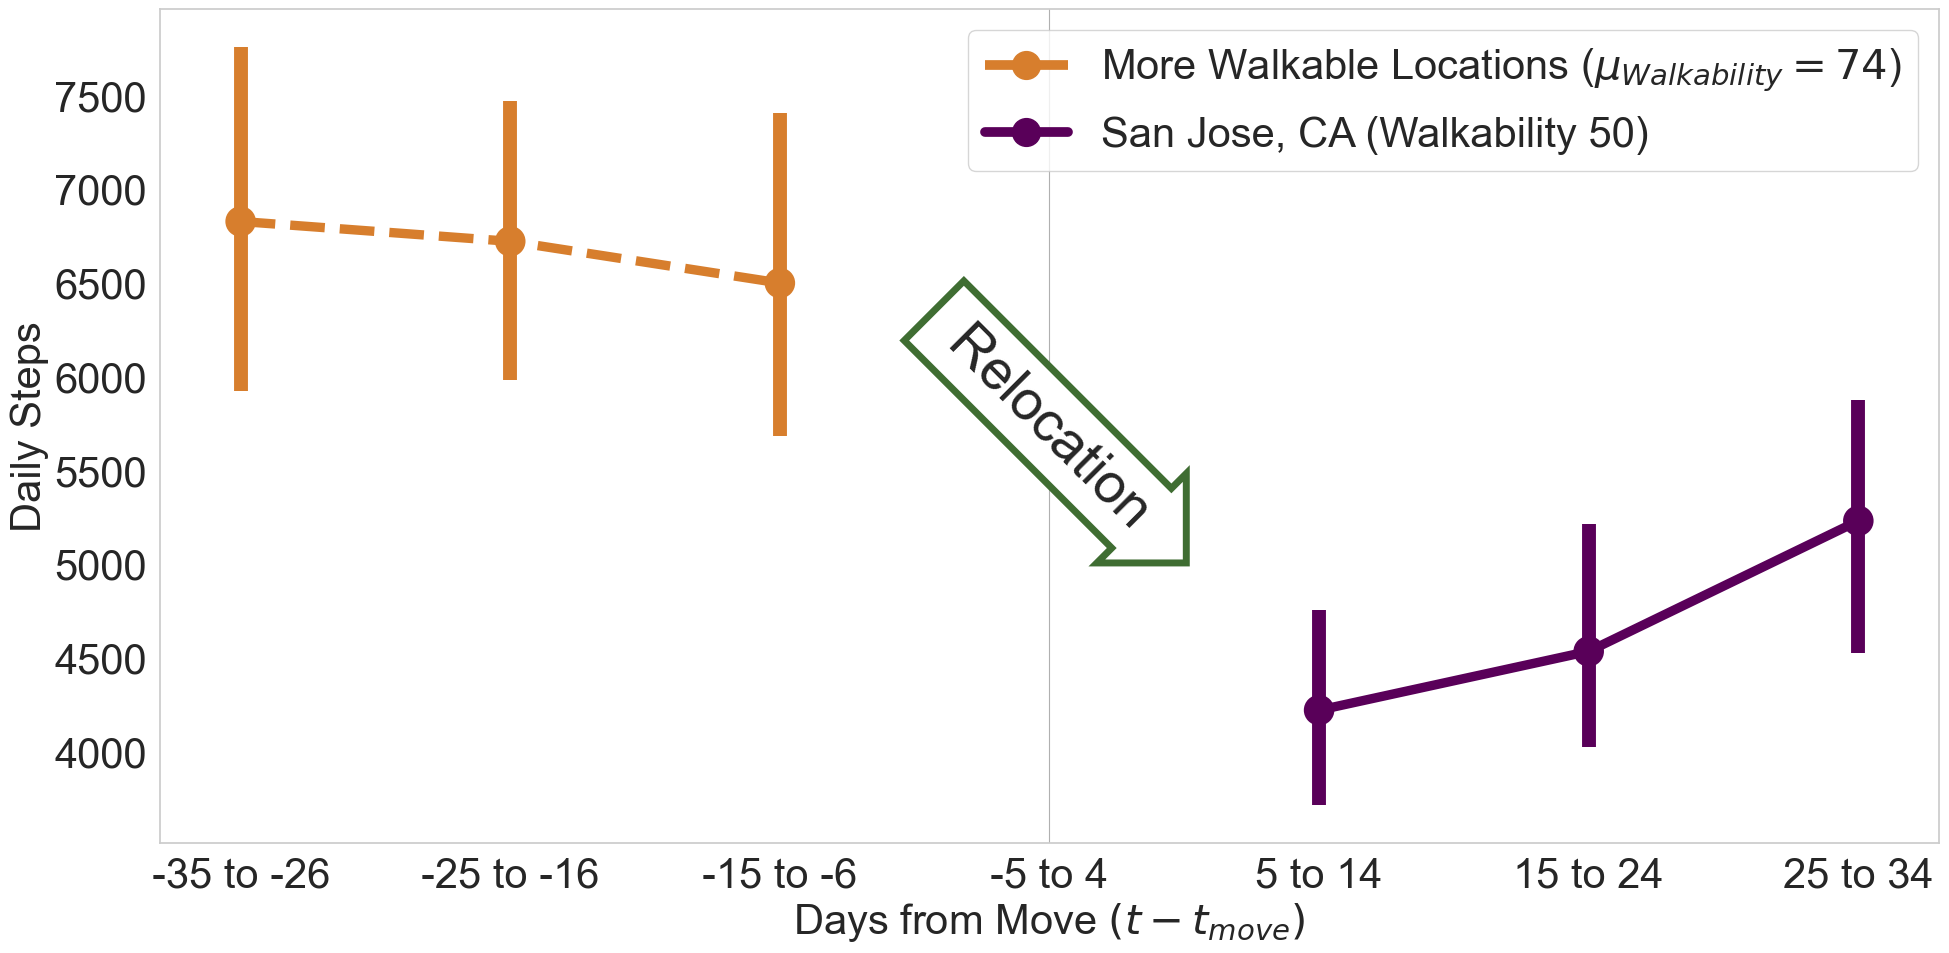

In [18]:
location = "San Jose, CA"
left_ws = 50
right_ws = 77

data_df = add_middle(pd.read_csv("../data/fig4/from_San_Jose_CA.csv")[
    ["move_relative_day_bin", "mean", "top_ci", "bottom_ci"]
])

ax = plot_timeseries_change_loc(data_df, location, '*',
                           come_from='below',
                           axis_fontsize=axis_fontsize, category_fontsize=category_fontsize,
                           middle_text_rotation=45,
                           auto_linestyle=True,
                           lgd_loc="upper left")

plt.savefig("../output/fig4c.pdf", dpi=300)


left_ws = 74
right_ws = 50

data_df = add_middle(pd.read_csv("../data/fig4/to_San_Jose_CA.csv")[
    ["move_relative_day_bin", "mean", "top_ci", "bottom_ci"]
])

ax = plot_timeseries_change_loc(data_df, '*', location, 
                           come_from="above",
                           axis_fontsize=axis_fontsize, category_fontsize=category_fontsize,
                           middle_text_rotation=-45,
                           auto_linestyle=True,
                           lgd_loc="upper right")

plt.savefig("../output/fig4d.pdf", dpi=300)

/tmp/ipykernel_95703/28736285.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=data_df["mean"].iloc[:3].tolist() + [np.nan]*4,
/tmp/ipykernel_95703/28736285.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=[np.nan]*4 + data_df["mean"].iloc[-3:].tolist(),
/tmp/ipykernel_95703/28736285.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=data_df["mean"].iloc[:3].tolist() + [np.nan]*4,
/tmp/ipykernel_95703/28736285.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=data_df[plot_x], y=[np.nan]*4 + data_df["mean"].iloc[-3:].tolist(),


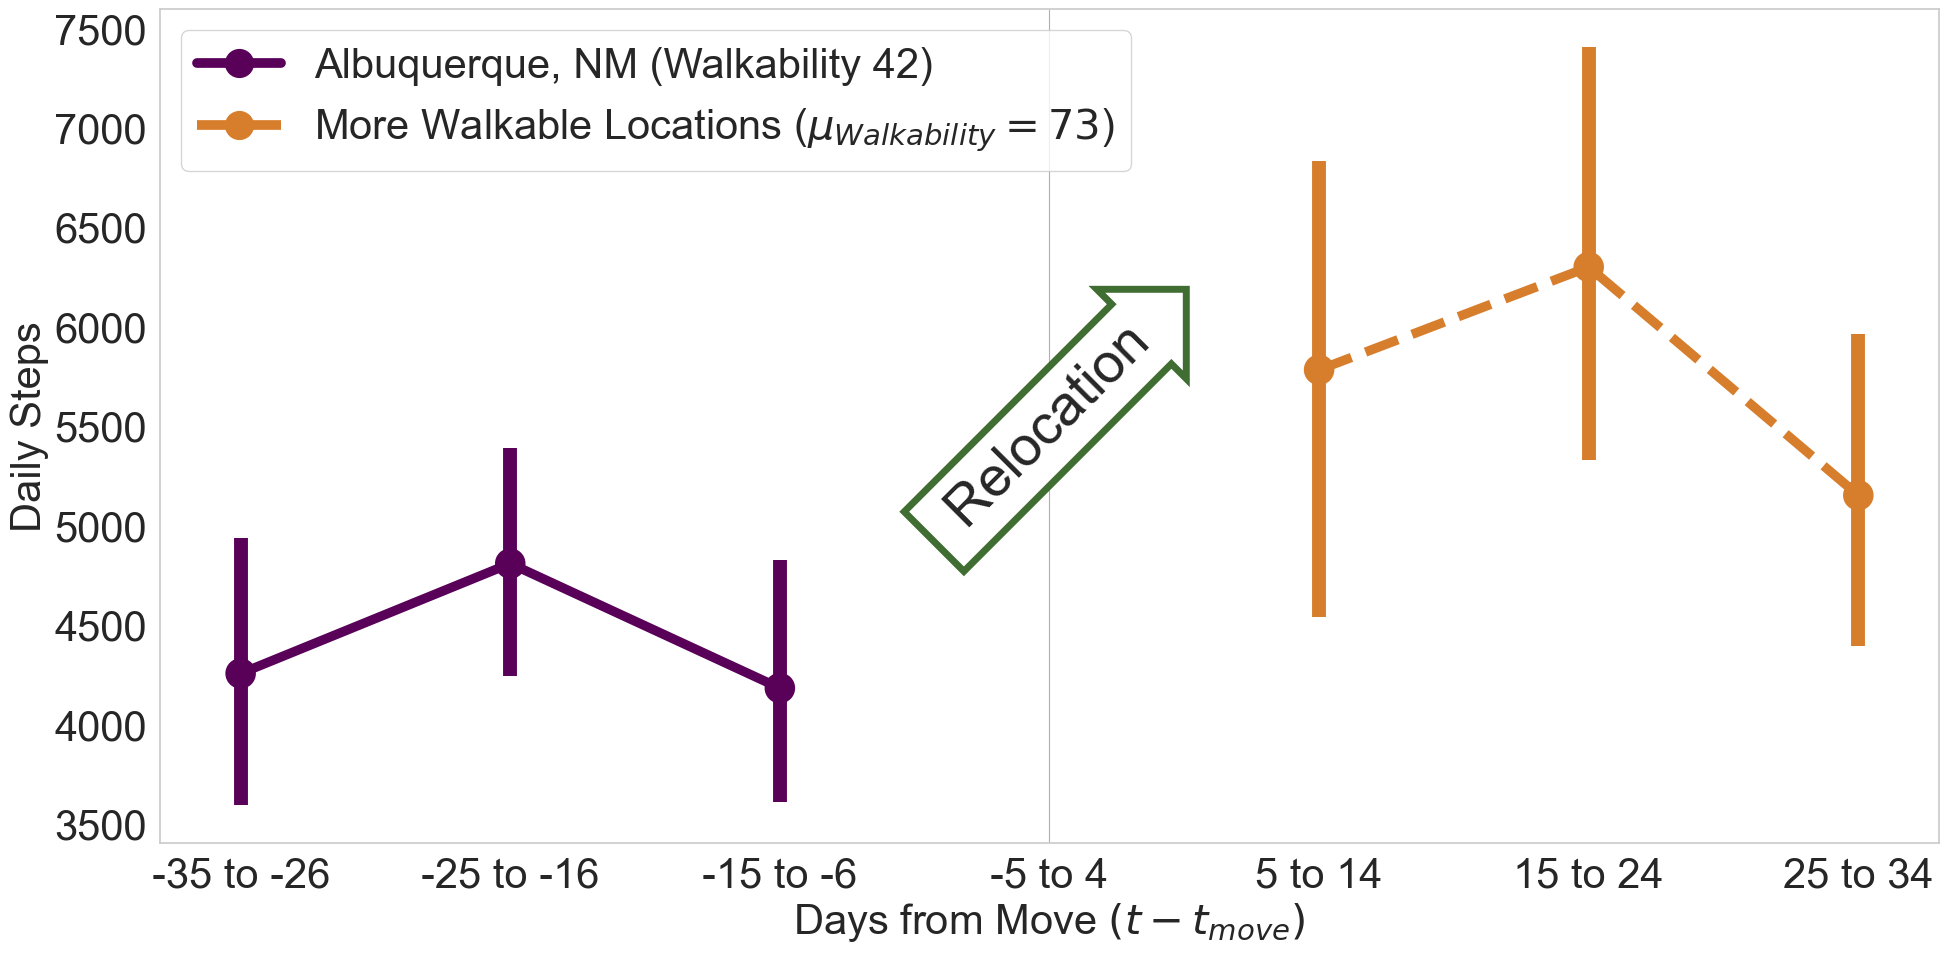

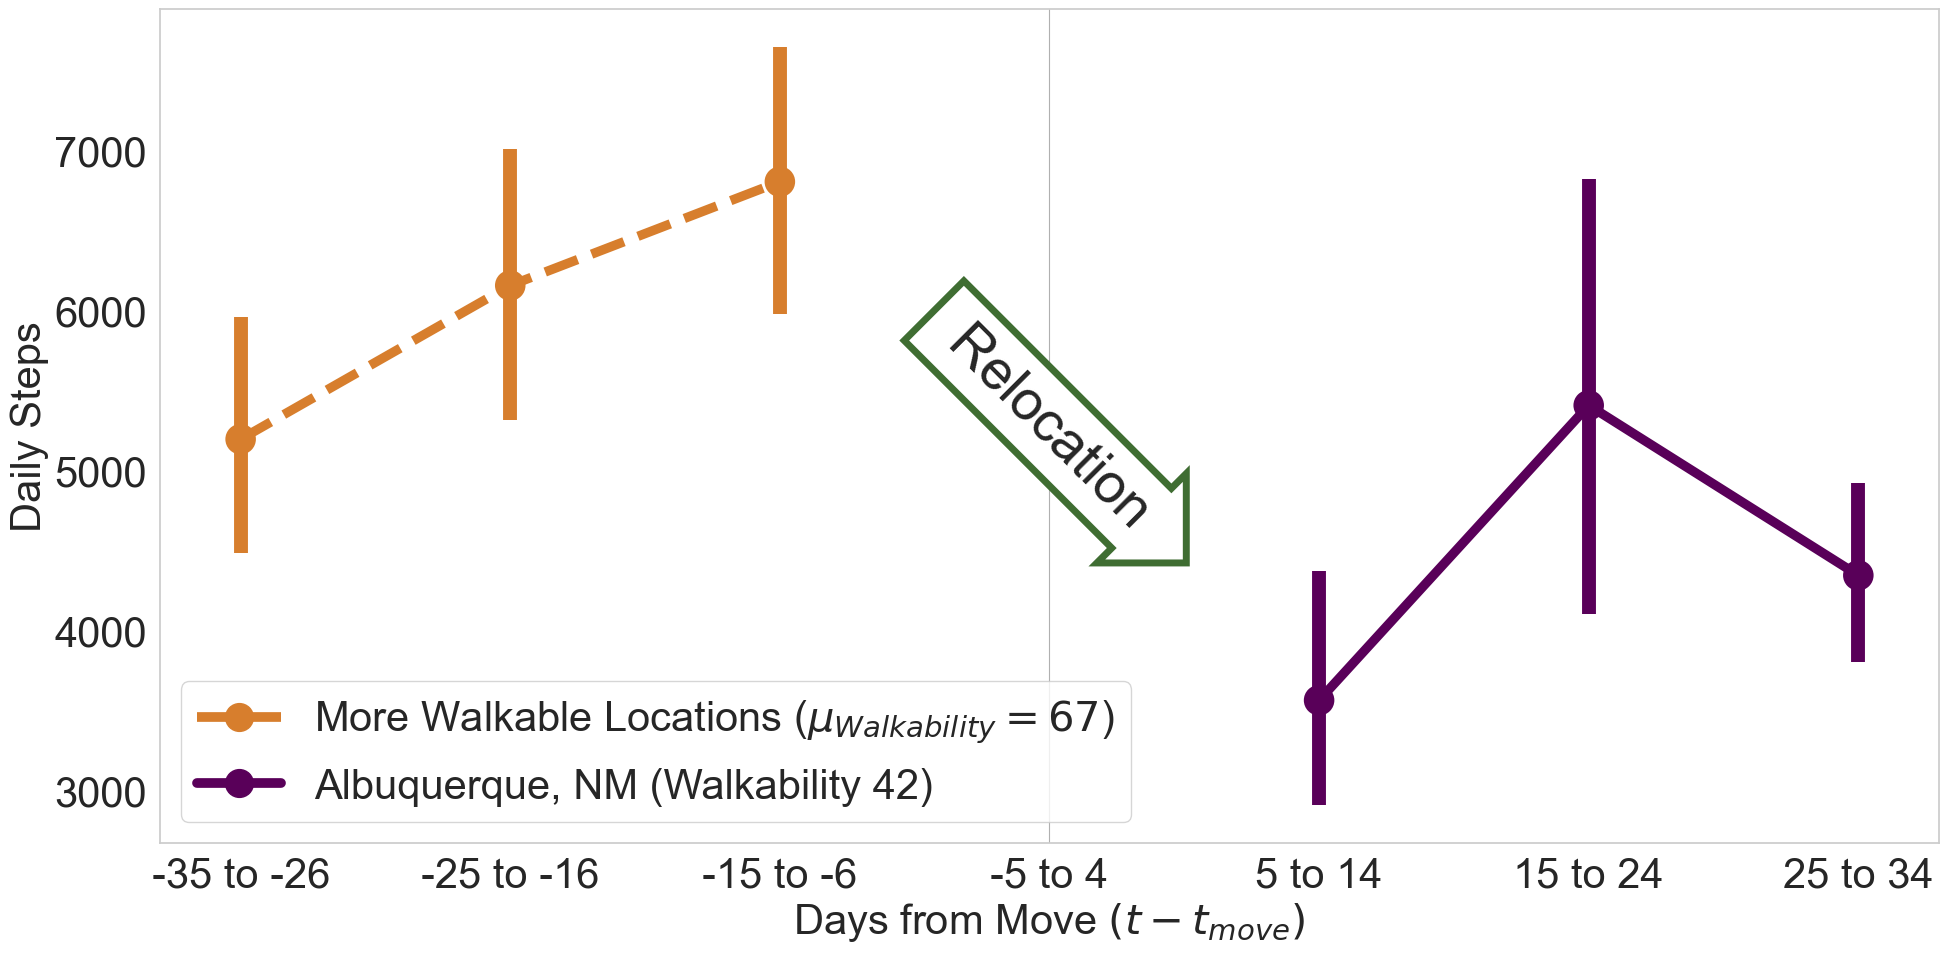

In [19]:
location = "Albuquerque, NM"
left_ws = 42
right_ws = 73

data_df = add_middle(pd.read_csv("../data/fig4/from_Albuquerque_NM.csv")[
    ["move_relative_day_bin", "mean", "top_ci", "bottom_ci"]
])

ax = plot_timeseries_change_loc(data_df, location, '*',
                           come_from='below',
                           axis_fontsize=axis_fontsize, category_fontsize=category_fontsize,
                           middle_text_rotation=45,
                           auto_linestyle=True,
                           lgd_loc="upper left")

plt.savefig("../output/fig4e.pdf", dpi=300)


left_ws = 67
right_ws = 42

data_df = add_middle(pd.read_csv("../data/fig4/to_Albuquerque_NM.csv")[
    ["move_relative_day_bin", "mean", "top_ci", "bottom_ci"]
])

ax = plot_timeseries_change_loc(data_df, '*', location, 
                           come_from="above",
                           axis_fontsize=axis_fontsize, category_fontsize=category_fontsize,
                           middle_text_rotation=-45,
                           auto_linestyle=True,
                           lgd_loc="lower left")

plt.savefig("../output/fig4f.pdf", dpi=300)